<a href="https://colab.research.google.com/github/mubarakabaz/Pemodelan/blob/main/MK_Pemodelan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Diketahui sebuah sungai terdapat input buangan yang telah melalui proses pengolahan dengan metode aerasi dengan gambaran sebagai berikut :

![Screenshot_212221.jpg](https://i.ibb.co.com/8m8c8r8/Screenshot-212221.jpg)

**Potongan A-A adalah :**
Koefisien reaerasi (ϴ1) = 1,05
Koefisien deksigenasi i (ϴ2) = 1,02
Koefisien waktu penguraian :
K1 (20) = 0,23 hari^–1 untuk reaerasi;
K2 (20) = 3,00 hari^–1 untuk reaerasi

**Ditanyakan**:
1. Berapa BOD Maksimum yang boleh dibuang ke sungai ?
2. Berapa efisiensi pengolahan yang seharusnya ada dan dimiliki oleh sumber
buangan?;
3. Bagaimana gambar profil pencemaran yang terjadi?.

**Gunakan metode Stretter Pelp untuk menyelesaikan masalah ini**

Sebelum memulai perhitungan ini, saya mengimpor library yang saya butuhkan terlebih dahulu.
  * Mengimpor library numpy untuk operasi numerik, matplotlib.pyplot untuk visualisasi, dan fsolve dari scipy.optimize untuk menyelesaikan persamaan non-linier.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

Setelah mengimpor semua library yang saya perlukan. saya mendefinisikan variabel-variabel yang telah diketahui sebelumnya.
* Mendefinisikan variabel-variabel yang diketahui dari soal, seperti debit sungai (Q1), debit buangan (Q2), BOD sungai (C1), BOD buangan (C2), DO (Dissolved Oxygen) sungai, DO buangan, suhu sungai, suhu buangan, koefisien reaerasi (K2_20), koefisien deoksigenasi (K1_20), faktor koreksi suhu untuk reaerasi (theta1), faktor koreksi suhu untuk deoksigenasi (theta2), baku mutu DO (DO_baku_mutu), dan DO jenuh (DO_sat).

In [ ]:
# Parameter-parameter dari soal
Q1 = 250  # Debit sungai (m³/detik)
Q2 = 125  # Debit buangan (m³/detik)
C1 = 20    # BOD sungai (mg/l)
C2 = 800   # BOD buangan (mg/l)
DO_sungai = 6  # DO sungai (mg/l)
DO_buangan = 8  # DO buangan (mg/l)
suhu_sungai = 31  # Suhu sungai (°C)
suhu_buangan = 22  # Suhu buangan (°C)
K2_20 = 0.23  # Koefisien reaerasi pada 20 °C (hari⁻¹)
K1_20 = 3.00  # Koefisien deoksigenasi pada 20 °C (hari⁻¹)
theta1 = 1.047  # Faktor koreksi suhu untuk reaerasi
theta2 = 1.024  # Faktor koreksi suhu untuk deoksigenasi
DO_baku_mutu = 5  # Baku mutu DO (mg/l)
DO_sat = 8.2  # DO jenuh pada suhu campuran (diasumsikan)

Setelah mengetahui variabel-variabel yang dibutuhkan. Selanjutnya memulai untuk melakukan perhitungan.

**1. Menghitung BOD, DO, dan Suhu Campuran**
  * Menghitung BOD campuran (CO), DO campuran, dan suhu campuran menggunakan rumus neraca massa:

In [ ]:
# 1. Menghitung BOD, DO, dan suhu campuran
CO = (Q1 * C1 + Q2 * C2) / (Q1 + Q2)
DO_campuran = (Q1 * DO_sungai + Q2 * DO_buangan) / (Q1 + Q2)
suhu_campuran = (Q1 * suhu_sungai + Q2 * suhu_buangan) / (Q1 + Q2)

print("BOD:", CO, "mg/l")
print("DO:", DO_campuran, "mg/l")
print("Suhu:", suhu_campuran, "°C")

BOD: 280.0 mg/l
DO: 6.666666666666667 mg/l
Suhu: 28.0 °C


**2. Menghitung K1 dan K2 pada suhu campuran**
* Menghitung koefisien deoksigenasi (K1) dan koefisien reaerasi (K2) pada suhu campuran menggunakan rumus:

In [ ]:
# 2. Menghitung K1 dan K2 pada suhu campuran
K1 = K1_20 * theta2**(suhu_campuran - 20)
K2 = K2_20 * theta1**(suhu_campuran - 20)

print("K1:", K1, "hari⁻¹")
print("K2:", K2, "hari⁻¹")

K1: 3.626777458843888 hari⁻¹
K2: 0.33212478742359985 hari⁻¹


**3. Menghitung defisit oksigen awal (Da) dan Kritis (Dc)**
* Menghitung defisit oksigen awal (Da) dan defisit oksigen kritis (Dc) menggunakan rumus:

In [ ]:
# 3. Menghitung defisit oksigen awal (Da) dan kritis (Dc)
Da = DO_sat - DO_campuran
Dc = DO_sat - DO_baku_mutu

print("Defisit oksigen awal (Da):", Da, "mg/l")
print("Kritis (Dc):", Dc, "mg/l")

Defisit oksigen awal (Da): 1.5333333333333323 mg/l
Kritis (Dc): 3.1999999999999993 mg/l


**4. Mendefinisikan Persamaan Streeter-Phelps untuk mencari tc**
* Mendefinisikan fungsi persamaan_streeter_phelps yang mewakili persamaan Streeter-Phelps:

In [ ]:
# 4. Mendefinisikan persamaan Streeter-Phelps untuk mencari tc
def persamaan_streeter_phelps(t, *data):
    K1, K2, La, Da, Dc = data
    return ((K1 * La) / (K2 - K1)) * (np.exp(-K1 * t) - np.exp(-K2 * t)) + Da * np.exp(-K1 * t) - Dc

**5. Mencari BOD ultimate (La) terlebih dahulu, menggunakan BOD campuran sebagai perkiraan awal La**
* Mencari nilai BOD ultimate (La) dengan menggunakan fsolve.
* Menggunakan BOD campuran sebagai perkiraan awal La.
* Memperbaiki nilai La setelah mendapatkan waktu kritis (tc).

In [ ]:
# 5. Mencari BOD ultimate (La) terlebih dahulu
La = CO  # Menggunakan BOD campuran sebagai perkiraan awal La

print("BOD ultimate (La):", La, "mg/l")

BOD ultimate (La): 280.0 mg/l


**6. Mencari waktu kritis (tc) dan perbaikan La berdasarkan tc**
* Mencari nilai waktu kritis (tc) dengan menggunakan fsolve.
Menggunakan nilai La yang telah dihitung sebelumnya.

In [ ]:
# 6. Mencari waktu kritis (tc) dan perbaikan La berdasarkan tc
tc_awal = 0.1  # Tebakan awal untuk tc
data = (K1, K2, La, Da, Dc)

tc = fsolve(persamaan_streeter_phelps, tc_awal, args=data)[0]

# Setelah mendapatkan tc, hitung La kembali menggunakan nilai tc
La = (K1 * Dc) / (K2 * (np.exp(-K2 * tc) - np.exp(-K1 * tc))) + Da * np.exp(-K1 * tc)

print("Waktu kritis (tc):", tc, "hari")
print("La setelah perbaikan:", La, "mg/l")

Waktu kritis (tc): 0.0016556863963046809 hari
La setelah perbaikan: 6428.470520580356 mg/l


**7. Menghitung BOD Maksimum yang diperbolehkan**
* Menghitung BOD maksimum yang diperbolehkan (BOD_maks) menggunakan rumus:

In [ ]:
# 7. Menghitung BOD maksimum yang diperbolehkan
BOD_maks = La / np.exp(K1 * tc)

print("BOD maksimum yang diperbolehkan:", BOD_maks, "mg/l")

BOD maksimum yang diperbolehkan: 6389.98446786328 mg/l


**8. Menghitung efisieensi pengolahan**
* Menghitung efisiensi pengolahan yang diperlukan menggunakan rumus:

In [ ]:
# 8. Menghitung efisiensi pengolahan
C2_akhir = ((Q1 + Q2) * BOD_maks - Q1 * C1) / Q2
efisiensi = ((C2 - C2_akhir) / C2) * 100

print("Efisiensi pengolahan:", efisiensi, "%")

Efisiensi pengolahan: -2291.24417544873 %


**9. Membuat Profil Pencemaran**
* Mendefinisikan fungsi streeter_phelps untuk menghitung defisit oksigen (Dt) pada waktu t.
* Menghasilkan data untuk profil pencemaran dengan menghitung Dt dan DO untuk 100 titik waktu antara 0 dan 1 hari.



In [ ]:
# 9. Membuat profil pencemaran
def streeter_phelps(t):
    return ((K1 * La) / (K2 - K1)) * (np.exp(-K1 * t) - np.exp(-K2 * t)) + Da * np.exp(-K1 * t)

t = np.linspace(0, 1, 100)  # Menghasilkan 100 titik waktu antara 0 dan 1 hari
Dt = streeter_phelps(t)
DO = DO_sat - Dt

**10. Memvisualisasikan data**
* Membuat plot profil pencemaran yang menunjukkan defisit oksigen (Dt) dan DO terhadap waktu.
* Menambahkan garis horizontal untuk DO jenuh dan baku mutu DO.

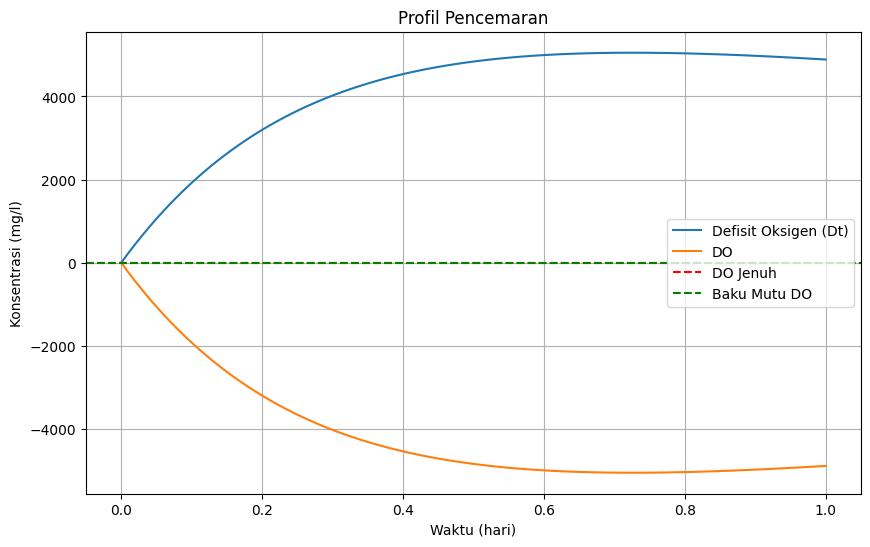

In [ ]:
# 10. Visualisasi
plt.figure(figsize=(10, 6))
plt.plot(t, Dt, label='Defisit Oksigen (Dt)')
plt.plot(t, DO, label='DO')
plt.axhline(y=DO_sat, color='r', linestyle='--', label='DO Jenuh')
plt.axhline(y=DO_baku_mutu, color='g', linestyle='--', label='Baku Mutu DO')
plt.xlabel('Waktu (hari)')
plt.ylabel('Konsentrasi (mg/l)')
plt.title('Profil Pencemaran')
plt.legend()
plt.grid(True)
plt.show()

Grafik menunjukkan bahwa defisit oksigen (Dt) cukup tinggi dan kadar oksigen terlarut (DO) turun di bawah baku mutu setelah pembuangan limbah. Hal ini menunjukkan bahwa kualitas air sungai menurun secara signifikan akibat pencemaran.

Grafik yang dihasilkan dari kode program tersebut adalah profil pencemaran yang menunjukkan perubahan defisit oksigen (Dt) dan kadar oksigen terlarut (DO) terhadap waktu setelah terjadi pembuangan limbah ke sungai.

**Sumbu X:** Waktu (hari)
**Sumbu Y:** Konsentrasi (mg/l)

**Kurva:**

Defisit Oksigen (Dt): Kurva ini menunjukkan seberapa besar kekurangan oksigen di dalam air sungai dibandingkan dengan kondisi jenuh. Semakin tinggi nilai Dt, semakin besar kekurangan oksigen, yang berarti kualitas air semakin buruk. Pada grafik, kurva Dt awalnya naik karena adanya limbah organik yang membutuhkan oksigen untuk dekomposisi, kemudian turun seiring dengan proses reaerasi (penyerapan oksigen dari atmosfer).
**DO:** Kurva ini menunjukkan kadar oksigen terlarut di dalam air sungai. Semakin tinggi nilai DO, semakin baik kualitas air. Kurva DO merupakan kebalikan dari kurva Dt, yaitu awalnya turun karena konsumsi oksigen oleh limbah organik, kemudian naik kembali karena reaerasi.

**Garis Horizontal:**

**DO Jenuh:** Garis ini menunjukkan kadar oksigen maksimum yang dapat larut dalam air pada suhu tertentu.
Baku Mutu DO: Garis ini menunjukkan batas minimum kadar oksigen terlarut yang harus dipenuhi agar kualitas air sungai dianggap baik.
Interpretasi Grafik:

**Waktu Kritis (tc):** Titik terendah pada kurva DO atau titik tertinggi pada kurva Dt menunjukkan waktu kritis (tc), yaitu waktu saat kadar oksigen terlarut mencapai nilai minimum.
**Defisit Oksigen Kritis (Dc):** Selisih antara DO jenuh dan DO pada waktu kritis menunjukkan defisit oksigen kritis (Dc).
Pemulihan Kualitas Air: Setelah waktu kritis, kurva DO naik dan kurva Dt turun, menunjukkan bahwa kualitas air mulai pulih karena proses reaerasi.
